# Investigating Bias Mitigation Algorithms in Predicting Student Dropout and Credit Card Approval

## Background and Rationale:

In recent years, the application of machine learning models in various domains has raised concerns regarding fairness and bias. As these models are increasingly used for critical decisions, in society or economics or education,. etc, such as student dropout prediction and credit card approval, it becomes imperative to ensure they do not have existing biases. 


This project aims to address these concerns by examining the effectiveness of different bias mitigation algorithms provided by IBM's AI Fairness 360 (AIF360) toolkit in reducing specific biases in the datasets. The societal and industrial relevance of this project lies in promoting fairer decision-making processes and enhancing trust in AI systems.

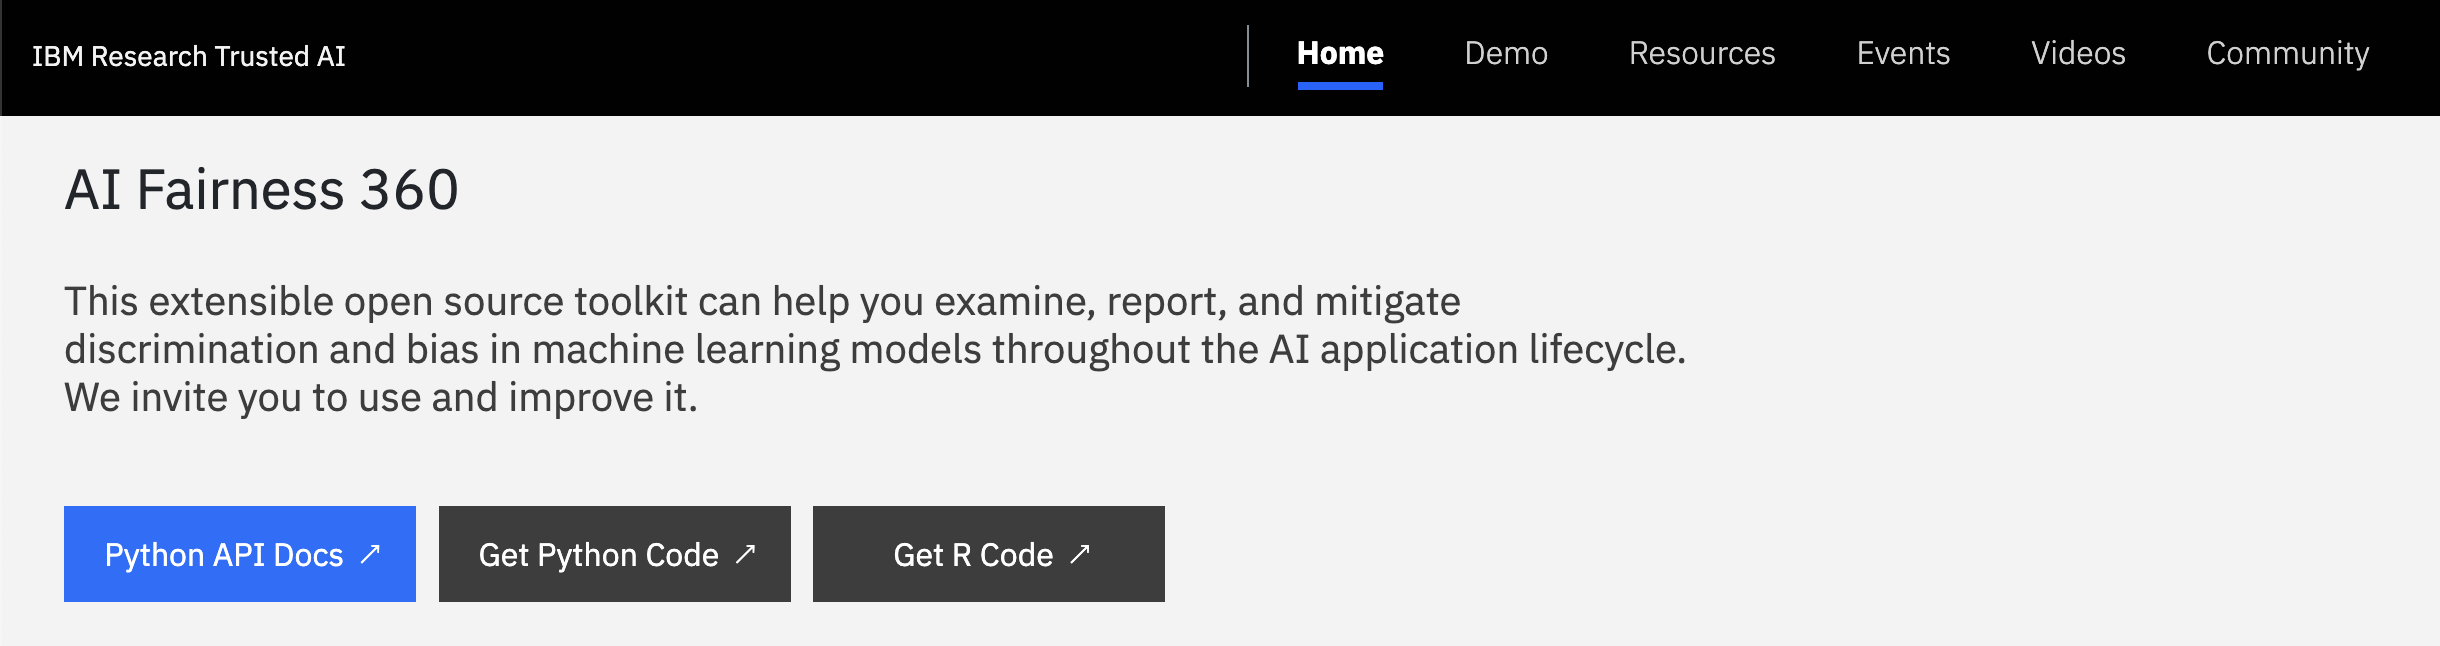

IBM AIF360 was chosen for several reasons:
1. **Comprehensive Toolset**: AIF360 provides a wide range of metrics and algorithms for detecting and mitigating bias, making it a versatile toolkit for fairness analysis.
2. **Established Framework**: It is an open-source library that is well-documented and widely used in both academic and industrial research, ensuring reliability and community support.
3. **Integration Capabilities**: AIF360 integrates seamlessly with popular machine learning frameworks such as scikit-learn, TensorFlow, and Pytorch, allowing for easy implementation in existing workflows.
4. **Extensive Fairness Metrics**: The toolkit offers various metrics to evaluate different types of biases, providing a comprehensive view of fairness in machine learning models.

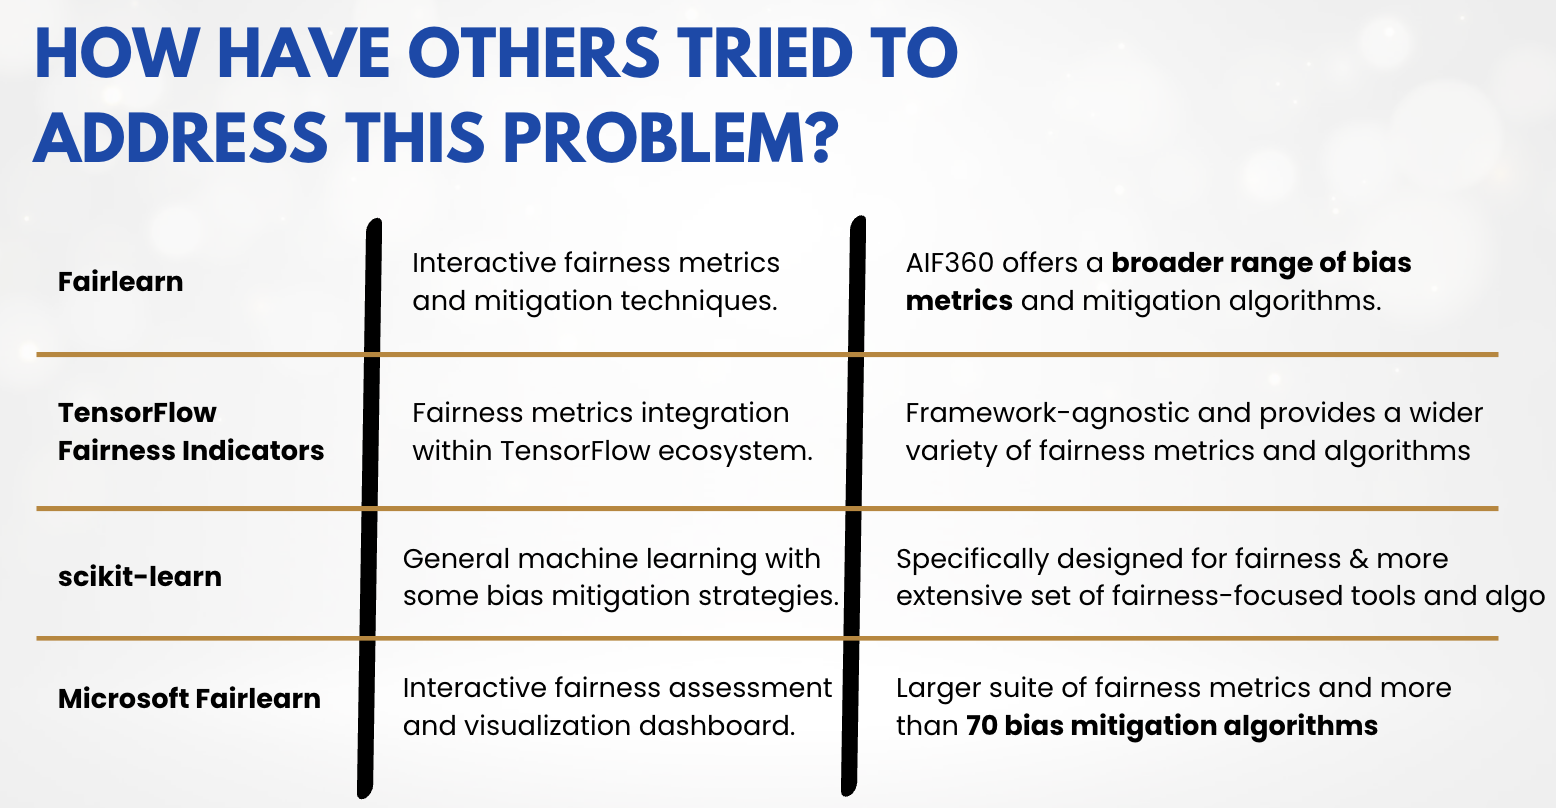

## Research questions:

- How do different bias metrics vary across the student dropout prediction and credit card approval datasets?
- How do different bias mitigation algorithms affect the bias metrics in both datasets? And which is the most suitable one?
- Which bias metrics show the most significant change after applying bias mitigation algorithm we selected?

## Our Datasets

1. Student Dropout Rate Prediction: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success
2. Credit Card Approval Prediction: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In these datasets, we define different use cases to assess fairness. The selected protected attributes for each dataset are:

- **Student Dropout Rate Prediction**:
  - Gender
  - Marital Status [Married or not]
  - Previous Qualification [Graduation]
  - Mother’s Qualification [Graduation]
  - Father’s Qualification [Graduation]
  

- **Credit Card Approval Prediction**:
  - Gender
  - Marital Status [Married or not]
  - Education [Higher or not]

--------------------------------------------------------------------------------
# Part 1: Investigating existing biases in both datastes

## Bias Metrics

Documentation: https://aif360.readthedocs.io/en/latest/modules/sklearn.html

Github Repository: https://github.com/Trusted-AI/AIF360

The metrics to evaluate the bias in the dataset:

1. Statistical Parity Difference: Measures the difference in the rate of favorable outcomes between protected and unprotected groups.
 
2. Disparate Impact: The ratio of favorable outcomes for protected vs. unprotected groups.

3. Average Odds Difference: Measures the average difference in false positive and true positive rates between groups.

4. Theil Index: Measures inequality in the distribution of a binary outcome.

5. Consistency: Checks consistency in the predictions for similar instances.

6. Mean Difference: Measures the difference in mean predicted scores between groups.

7. Generalized Entropy Index: Measures inequality in the distribution of an outcome with sensitivity to tail differences.

8. Base Rate: Computes the proportion of positive outcomes in the entire dataset.

9. Selection Rate: Calculates the proportion of positive outcomes within a specific group.

10. Equal Opportunity Difference: Difference in true positive rates between privileged and unprivileged groups.


1.1 Installing necessary libraries

In [2]:
!pip install aif360
!pip install cvxpy
!pip install 'aif360[AdversarialDebiasing]'
!pip install 'aif360[Reductions]'
!pip install 'aif360[inFairness]'

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.12.2
    Uninstalling typing-extensions-4.12.2:
      Successfully uninstalled typing-extensions-4.12.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

torch 2.3.1 requires typing-extensions>=4.8.0, but you'll have typing-extensions 4.5.0 which is incompatible.
tensorflow 2.13.1 requires numpy<=1.24.3,>=1.22, but you'll have numpy 1.19.1 which is incompatible.
infairness 0.2.3 requires numpy>=1.21.6, but you'll have numpy 1.19.1 which is incompatible.
infairness 0.2.3 requires pandas>=1.3.5, but you'll have pandas 1.1.2 which is incompatible.
infairness 0.2.3 requires scipy>=1.5.4, but you'll have scipy 1.5.2 which is incompatible.
  Attempting unins

### 1. Firstly, we examine **Student Drop-out rate** dataset

#### 1.1 Loading and preprocessing data, defining our function which prints 10 bias metrics we selected from the documentation, and testing with first use case (Gender Bias)

In [1]:
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from IPython.display import Markdown, display
        
def pretty_print_metric(metric, usecase):
    display(Markdown(f"### {usecase}"))
    display(Markdown("#### Statistical Parity Difference"))
    display(Markdown(f"`{metric.statistical_parity_difference():.4f}`"))
    display(Markdown("#### Disparate Impact"))
    display(Markdown(f"`{metric.disparate_impact():.4f}`"))
    display(Markdown("#### Equal Opportunity Difference"))
    display(Markdown(f"`{metric.equal_opportunity_difference():.4f}`"))
    display(Markdown("#### Average Odds Difference"))
    if isinstance(metric, ClassificationMetric):
        display(Markdown(f"`{metric.average_odds_difference():.4f}`"))
    else:
        display(Markdown("N/A"))
    display(Markdown("#### Base Rate"))
    display(Markdown(f"`{metric.base_rate():.4f}`"))
    display(Markdown("#### Selection Rate"))
    display(Markdown(f"`{metric.selection_rate():.4f}`"))
    display(Markdown("#### Theil Index"))
    display(Markdown(f"`{metric.theil_index():.4f}`"))
    display(Markdown("#### Consistency"))
    display(Markdown(f"`{metric.consistency().mean():.4f}`"))  # Taking the mean for display
    display(Markdown("#### Mean Difference"))
    display(Markdown(f"`{metric.mean_difference():.4f}`"))
    display(Markdown("#### Generalized Entropy Index"))
    display(Markdown(f"`{metric.generalized_entropy_index():.4f}`"))

# Load your data from dropout_data.csv
df = pd.read_csv('dropout_data.csv')

# Convert 'Dropout' to 1 and other values to 0 in the 'target' column
df['Target'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Ensure that the dataset includes columns for the protected attribute and the label
protected_attribute = 'Gender'
label = 'Target'

dataset = BinaryLabelDataset(
    favorable_label=0,  
    unfavorable_label=1,  # 1 is unfavorable (dropout)
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Male
unprivileged_groups = [{protected_attribute: 0}]  # Female

# Computing metrics to check fairness
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

pretty_print_metric(metric, "D1: Gender Bias")

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.8/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


### D1: Gender Bias

#### Statistical Parity Difference

`0.1995`

#### Disparate Impact

`1.3630`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.6788`

#### Selection Rate

`0.6788`

#### Theil Index

`0.0000`

#### Consistency

`0.7642`

#### Mean Difference

`0.1995`

#### Generalized Entropy Index

`0.0000`

#### 1.2 Analyzing Bias Metrics with the other 4 use cases in the Student Dropout Dataset

In [2]:
df['Marital status'].unique()

array([1, 2, 4, 3, 5, 6])

In [3]:
protected_attribute = 'Marital status'
label = 'Target'

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x == 1 else 0)

dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Single
unprivileged_groups = [{protected_attribute: 0}]  # Not Single

# Computing metrics to check fairness
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

pretty_print_metric(metric, "D1: Marital Status")

### D1: Marital Status

#### Statistical Parity Difference

`0.1672`

#### Disparate Impact

`1.5534`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`0.3212`

#### Theil Index

`0.0000`

#### Consistency

`0.7642`

#### Mean Difference

`0.1672`

#### Generalized Entropy Index

`0.0000`

In [5]:
protected_attribute = 'Previous qualification'
label = 'Target'

conversion_values = [2, 3, 4, 5, 39, 40, 42, 43]

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x in conversion_values else 0)

df[protected_attribute].unique()

dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Higher Education
unprivileged_groups = [{protected_attribute: 0}]  # Not Higher Education

# Computing metrics to check fairness
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

pretty_print_metric(metric, "D1: Own Educational Qualification")

### D1: Own Education Qualification

#### Statistical Parity Difference

`-0.0962`

#### Disparate Impact

`0.7639`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`0.3212`

#### Theil Index

`0.0000`

#### Consistency

`0.7669`

#### Mean Difference

`-0.0962`

#### Generalized Entropy Index

`0.0000`

In [6]:
protected_attribute = 'Mother\'s qualification'
label = 'Target'

conversion_values = [2, 3, 4, 5, 6, 22, 39, 40, 41, 42, 43, 44]

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x in conversion_values else 0)

df[protected_attribute].unique()

array([0, 1])

In [7]:
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Higher Education
unprivileged_groups = [{protected_attribute: 0}]  # Not Higher Education

# Computing metrics to check fairness
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

pretty_print_metric(metric, "D1: Mother's Educational Qualification")

### D1: Mother's Education Qualification

#### Statistical Parity Difference

`0.0199`

#### Disparate Impact

`1.0654`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`0.3212`

#### Theil Index

`0.0000`

#### Consistency

`0.7776`

#### Mean Difference

`0.0199`

#### Generalized Entropy Index

`0.0000`

In [8]:
protected_attribute = 'Father\'s qualification'
label = 'Target'

conversion_values = [2, 3, 4, 5, 6, 18, 22, 31, 33, 39, 40, 41, 42, 43, 44]

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x in conversion_values else 0)

df[protected_attribute].unique()

array([0, 1])

In [9]:
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,  # 0 is unfavorable (not single)
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Higher Education
unprivileged_groups = [{protected_attribute: 0}]  # Not Higher Education

# Computing metrics to check fairness
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

pretty_print_metric(metric, "D1: Father's Educational Qualification")

### D1: Father's Education Qualification

#### Statistical Parity Difference

`-0.0359`

#### Disparate Impact

`0.8985`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`0.3212`

#### Theil Index

`0.0000`

#### Consistency

`0.7854`

#### Mean Difference

`-0.0359`

#### Generalized Entropy Index

`0.0000`

### 2. Next, we examine the **Credit Card Approval Prediction** dataset

In [13]:
# Load your data from dropout_data.csv
application_record = pd.read_csv('application_record.csv')
credit_record = pd.read_csv('credit_record.csv')
    
# Make Male Gender = 1
application_record['CODE_GENDER'] = application_record['CODE_GENDER'].apply(lambda x: 1 if x == 'M' else 0)

# Make Married = 1
group_identifiers = ['Married', 'Civil marriage']
application_record['NAME_FAMILY_STATUS'] = application_record['NAME_FAMILY_STATUS'].apply(lambda x: 1 if x in group_identifiers else 0)

# Make Higher Education = 1
group_identifiers = ['Higher education', 'Academic degree']
application_record['NAME_EDUCATION_TYPE'] = application_record['NAME_EDUCATION_TYPE'].apply(lambda x: 1 if x in group_identifiers else 0)

# Convert 'Y'/'N' to 1/0 for FLAG_OWN_CAR and FLAG_OWN_REALTY
application_record['FLAG_OWN_CAR'] = application_record['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
application_record['FLAG_OWN_REALTY'] = application_record['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert STATUS to binary if no loan or no due = 1
credit_record['STATUS'] = credit_record['STATUS'].apply(lambda x: 1 if x in ['C', 'X'] else 0)

# Aggregate the STATUS to get the worst status per ID
credit_record = credit_record.groupby('ID')['STATUS'].min().reset_index()

# Merge the datasets on ID column
merged_data = pd.merge(application_record, credit_record, on='ID')

# Handle missing values
merged_data = merged_data.dropna()

# Identify categorical columns that need to be converted
categorical_columns = ['NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

# Convert categorical columns to numerical values using one-hot encoding
merged_data = pd.get_dummies(merged_data, columns=categorical_columns)

print("First few rows of the merged data:\n", merged_data.head())

First few rows of the merged data:
         ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
2  5008806            1             1                1             0   
3  5008808            0             0                1             0   
4  5008809            0             0                1             0   
5  5008810            0             0                1             0   
6  5008811            0             0                1             0   

   AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  DAYS_BIRTH  \
2          112500.0                    0                   1      -21474   
3          270000.0                    0                   0      -19110   
4          270000.0                    0                   0      -19110   
5          270000.0                    0                   0      -19110   
6          270000.0                    0                   0      -19110   

   DAYS_EMPLOYED  ...  OCCUPATION_TYPE_Laborers  \
2          -1134  ...  

In [14]:
protected_attribute = 'CODE_GENDER'
target = 'STATUS'

# Define privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}] 
unprivileged_groups = [{protected_attribute: 0}] # Women

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=merged_data,
    label_names=[target],
    protected_attribute_names=[protected_attribute]
)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print the initial fairness metrics
pretty_print_metric(metric, "D2: Gender Bias")

### D2: Gender Bias

#### Statistical Parity Difference

`-0.0051`

#### Disparate Impact

`0.9592`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.1231`

#### Selection Rate

`0.1231`

#### Theil Index

`0.0000`

#### Consistency

`0.8723`

#### Mean Difference

`-0.0051`

#### Generalized Entropy Index

`0.0000`

In [15]:
protected_attribute = 'NAME_FAMILY_STATUS'
target = 'STATUS'

# Define privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}] 
unprivileged_groups = [{protected_attribute: 0}] # Single

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=merged_data,
    label_names=[target],
    protected_attribute_names=[protected_attribute]
)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print the initial fairness metrics
pretty_print_metric(metric, "D2: Marital Status")

### D2: Marital Status

#### Statistical Parity Difference

`-0.0116`

#### Disparate Impact

`0.9075`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.1231`

#### Selection Rate

`0.1231`

#### Theil Index

`0.0000`

#### Consistency

`0.8723`

#### Mean Difference

`-0.0116`

#### Generalized Entropy Index

`0.0000`

In [16]:
protected_attribute = 'NAME_EDUCATION_TYPE'
target = 'STATUS'

# Define privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}] 
unprivileged_groups = [{protected_attribute: 0}] # Not Higher Education

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=merged_data,
    label_names=[target],
    protected_attribute_names=[protected_attribute]
)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print the initial fairness metrics
pretty_print_metric(metric, "D2: Education Level")

### D2: Education Level

#### Statistical Parity Difference

`-0.0064`

#### Disparate Impact

`0.9500`

#### Equal Opportunity Difference

`0.0000`

#### Average Odds Difference

`0.0000`

#### Base Rate

`0.1231`

#### Selection Rate

`0.1231`

#### Theil Index

`0.0000`

#### Consistency

`0.8723`

#### Mean Difference

`-0.0064`

#### Generalized Entropy Index

`0.0000`

### 3. Bias Metrics Results

After computing the bias metrics for both datasets (Student Dropout Rate Prediction and Credit Card Approval Prediction), we compile the results into a single table. This table presents the metrics for each protected attribute, allowing us to visualize and compare the levels of bias across different attributes and datasets.

The table uses color coding to highlight the results:
- **<span style="color:green">Green</span>**: Indicates neutral or insignificant bias (values between 0 and 1).
- **<span style="color:black; background-color:white;">Black</span>**: Indicates minimal or no bias (values equal to 0).
- **<span style="color:red">Red</span>**: Indicates significant bias (values greater than 1 or less than 0).

The following table summarizes the bias metrics results:

<table>
  <tr>
    <th style="width:5%">No.</th>
    <th style="width:10%">Metric</th>
    <th style="width:25%">Explanation</th>
    <th style="width:20%">Significance</th>
    <th style="width:5%">Gender (Dropout)</th>
    <th style="width:5%">Marital Status (Dropout)</th>
    <th style="width:5%">Previous Qualification (Dropout)</th>
    <th style="width:5%">Father's Qualification (Dropout)</th>
    <th style="width:5%">Mother's Qualification (Dropout)</th>
    <th style="width:5%">Gender (Credit)</th>
    <th style="width:5%">Marital Status (Credit)</th>
    <th style="width:5%">Education (Credit)</th>
  </tr>
  <tr>
    <td>1</td>
    <td><code>metrics.statistical_parity_difference(y_true)</code></td>
    <td>Statistical Parity Difference (SPD) calculates the difference in rates at which the positive outcome is predicted for the privileged group compared to the unprivileged group.</td>
    <td>> 0: Positive values indicate a bias favoring the privileged group (Male) <br> < 0: Negative values show a bias favoring unprivileged group (Female) <br> = 0: Indicates that both groups have equal probabilities of receiving the positive outcome, demonstrating fairness</td>
    <td><span style="color:red">0.1995</span></td>
    <td><span style="color:red">0.1672</span></td>
    <td><span style="color:green">-0.0962</span></td>
    <td><span style="color:green">-0.0359</span></td>
    <td><span style="color:green">0.0199</span></td>
    <td><span style="color:green">-0.0051</span></td>
    <td><span style="color:green">-0.0116</span></td>
    <td><span style="color:green">-0.0064</span></td>
  </tr>
  <tr>
    <td>2</td>
    <td><code>metrics.disparate_impact_ratio(y_true[, ...])</code></td>
    <td>Disparate Impact Ratio is defined as the ratio of the rate of favorable outcomes for the unprivileged group to the rate of favorable outcomes for the privileged group.</td>
    <td>A disparate impact ratio of 1 indicates perfect fairness, meaning both groups are equally likely to receive favorable outcomes. A value less than 1 indicates a bias against the unprivileged group, while a value greater than 1 indicates a bias in favor of the unprivileged group.</td>
    <td><span style="color:red">1.3630</span></td>
    <td><span style="color:red">1.5534</span></td>
    <td><span style="color:red">0.7369</span></td>
    <td><span style="color:red">0.8985</span></td>
    <td><span style="color:red">1.0654</span></td>
    <td><span style="color:red">0.9592</span></td>
    <td><span style="color:red">0.9075</span></td>
    <td><span style="color:red">0.9500</span></td>
  </tr>
  <tr>
    <td>3</td>
    <td><code>metrics.average_odds_difference(y_true, ...)</code></td>
    <td>Average Odds Difference (AOD) is defined as the average of the difference in false positive rates (FPR) and the difference in true positive rates (TPR) between unprivileged and privileged groups.</td>
    <td>A value of 0 indicates equal treatment across both positive and negative outcomes between the groups. Positive values indicate a bias in favor of the unprivileged group, whereas negative values indicate a bias against the unprivileged group.</td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
  </tr>
  <tr>
    <td>4</td>
    <td><code>metrics.theil_index(b)</code></td>
    <td>Theil Index is derived from information theory and economics, where it is traditionally used to measure economic inequality.</td>
    <td>A Theil Index of 0 indicates perfect equality, meaning every group receives exactly the same outcomes. Values greater than 0 indicate increasing levels of inequality, with higher values signaling more severe disparities.</td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
  </tr>
  <tr>
    <td>5</td>
    <td><code>metrics.consistency_score(X, y[, n_neighbors])</code></td>
    <td>Consistency Score: Typically calculated by first finding the k-nearest neighbors for each data point in the feature space and then assessing how similar the labels are within this local neighborhood.</td>
    <td>A consistency score of 1 indicates perfect consistency, where all k-nearest neighbors of every instance always have the same label, implying that the model treats similar instances in a similar manner regardless of their group memberships.</td>
    <td><span style="color:red">0.7642</span></td>
    <td><span style="color:red">0.7642</span></td>
    <td><span style="color:red">0.7669</span></td>
    <td><span style="color:red">0.7854</span></td>
    <td><span style="color:red">0.7776</span></td>
    <td><span style="color:red">0.8723</span></td>
    <td><span style="color:red">0.8723</span></td>
    <td><span style="color:red">0.8723</span></td>
  </tr>
  <tr>
    <td>6</td>
    <td><code>metrics.mean_difference(y_true[, y_pred, ...])</code></td>
    <td>Mean Difference measures the arithmetic difference between the average predicted outcome (or actual outcome, depending on the context) for the privileged group and that for the unprivileged group.</td>
    <td>A mean difference of 0 implies that, on average, both groups receive the same outcome, indicating no disparity. <br> > 0: positive value indicates that the privileged group has a higher average outcome</td>
    <td><span style="color:red">0.1995</span></td>
    <td><span style="color:red">0.1672</span></td>
    <td><span style="color:green">-0.0962</span></td>
    <td><span style="color:green">-0.0359</span></td>
    <td><span style="color:green">0.0199</span></td>
    <td><span style="color:green">-0.0051</span></td>
    <td><span style="color:green">-0.0116</span></td>
    <td><span style="color:green">-0.0064</span></td>
  </tr>
  <tr>
    <td>7</td>
    <td><code>metrics.generalized_entropy_index(b[, alpha])</code></td>
    <td>Generalized Entropy Index (GEI) quantifies inequality by considering the deviations of individual outcomes from the mean outcome, which is a common approach in economics for measuring income inequality.</td>
    <td>A GEI of 0 indicates perfect equality, meaning every group receives exactly the same outcomes. Values greater than 0 indicate increasing levels of inequality, with higher values signaling more severe disparities.</td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
  </tr>
  <tr>
    <td>8</td>
    <td><code>metrics.base_rate(y_true[, y_pred, ...])</code></td>
    <td>Base Rate: The base rate is the proportion of instances that belong to the positive class.</td>
    <td>Understanding the base rate is essential for evaluating model performance, particularly in scenarios with imbalanced classes. A high base rate might indicate a higher number of positive instances relative to negative ones, or vice versa.</td>
    <td><span style="color:red">0.6788</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.1231</span></td>
    <td><span style="color:red">0.1231</span></td>
    <td><span style="color:red">0.1231</span></td>
  </tr>
  <tr>
    <td>9</td>
    <td><code>metrics.selection_rate(y_true, y_pred, *[, ...])</code></td>
    <td>Selection Rate: The proportion of instances that are predicted as positive by the model, regardless of their actual class labels.</td>
    <td>This metric helps in understanding whether the model is too conservative or too liberal in predicting positive or negative outcomes. It is crucial for evaluating fairness, especially in scenarios where there is a significant disparity between different demographic groups.</td>
    <td><span style="color:red">0.6788</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.3212</span></td>
    <td><span style="color:red">0.1231</span></td>
    <td><span style="color:red">0.1231</span></td>
    <td><span style="color:red">0.1231</span></td>
  </tr>
  <tr>
    <td>10</td>
    <td><code>metrics.equal_opportunity_difference(y_true, ...)</code></td>
    <td>Equal Opportunity Difference compares the true positive rates (TPR) between the privileged and unprivileged groups.</td>
    <td>A value of 0 indicates equal opportunity, meaning both groups have the same probability of receiving a positive prediction when they are actually positive. Positive values indicate a bias in favor of the unprivileged group, whereas negative values indicate a bias against the unprivileged group.</td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
    <td><span style="color:black; background-color:white;">0.0000</span></td>
  </tr>
</table>

#### Key Observations:

For the student dropout rate prediction dataset

- **Gender**: there is significant bias as indicated by the red cells for statistical parity difference, disparate impact ratio, consistency score, mean difference, base rate, and selection rate.
- **Marital Status**: significant bias is present as indicated by the red cells for statistical parity difference, disparate impact ratio, consistency score, mean difference, base rate, and selection rate.
- **Previous Qualification**: notable bias is observed in disparate impact ratio and consistency score.
- **Father's Qualification and Mother's Qualification**: Minimal to no bias is observed across most metrics, indicating fair treatment in these categories.

For the credit card approval prediction dataset, significant bias is present in disparate impact ratio and consistency score across gender, marital status, and education. This indicates that these areas need mitigation efforts to ensure fairness.

--------------------------------------------------------------------------------

# Part 2: Applying Bias mitigation algorithms

# Supported bias mitigation algorithms

1. Optimized Preprocessing (Calmon et al., 2017)
2. Disparate Impact Remover (Feldman et al., 2015)
3. Equalized Odds Postprocessing (Hardt et al., 2016)
4. Reweighing (Kamiran and Calders, 2012)
5. Reject Option Classification (Kamiran et al., 2012)
6. Prejudice Remover Regularizer (Kamishima et al., 2012)
7. Calibrated Equalized Odds Postprocessing (Pleiss et al., 2017)
8. Learning Fair Representations (Zemel et al., 2013)
9. Adversarial Debiasing (Zhang et al., 2018)
10. Meta-Algorithm for Fair Classification (Celis et al., 2018)
11. Rich Subgroup Fairness (Kearns, Neel, Roth, Wu, 2018)
12. Exponentiated Gradient Reduction (Agarwal et al., 2018)
13. Grid Search Reduction (Agarwal et al., 2018, Agarwal et al., 2019)
14. Fair Data Adaptation (Plečko and Meinshausen, 2020, Plečko et al., 2021)
15. Sensitive Set Invariance/Sensitive Subspace Robustness (Yurochkin and Sun, 2020, Yurochkin et al., 2019)

### Upon further investigation we categorised them into three categories

#### Data (Pre-processing)

1. Optimized Preprocessing
2. Disparate Impact Remover
3. Reweighing
4. Learning Fair Representations

#### Models (In-processing)

1. Equalized Odds Postprocessing
2. Prejudice Remover Regularizer
3. Calibrated Equalized Odds Postprocessing
4. Adversarial Debiasing
5. Meta-Algorithm for Fair Classification
6. Rich Subgroup Fairness
7. Exponentiated Gradient Reduction
8. Grid Search Reduction
9. Sensitive Set Invariance/Sensitive Subspace Robustness
10. Fair Data Adaptation

#### Data (Post-processing)

1. Reject Option Classification

Firstly, based on bias metrics result, we will clean the data by removing four metrics, resulting in 0.0000, which are not existing in both datasets

Secondly, we define that four bias mitigation algorithms applied for Data (pre-processing) are potential to mitigate biases in two datasets.
However, in order to choose the most suitable one, we will apply all those four algorithms on Gender Bias use case in Student Drop-out rate dataset and see how is the performance.

In [12]:
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from IPython.display import Markdown, display

# Load your data from dropout_data.csv
df = pd.read_csv('dropout_data.csv')

# Convert 'Dropout' to 1 and other values to 0 in the 'target' column
df['Target'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Ensure that the dataset includes columns for the protected attribute and the label
protected_attribute = 'Gender'
label = 'Target'

dataset = BinaryLabelDataset(
    favorable_label=0,  
    unfavorable_label=1,  # 1 is unfavorable (dropout)
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Male
unprivileged_groups = [{protected_attribute: 0}]  # Female

# Computing metrics to check fairness
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Compute initial fairness metrics
metric = ClassificationMetric(
    dataset,
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

def pretty_print_metric(metric, usecase):
    display(Markdown(f"### {usecase}"))
    display(Markdown("#### Statistical Parity Difference"))
    display(Markdown(f"`{metric.statistical_parity_difference():.4f}`"))
    display(Markdown("#### Disparate Impact"))
    display(Markdown(f"`{metric.disparate_impact():.4f}`"))
    display(Markdown("#### Base Rate"))
    display(Markdown(f"`{metric.base_rate():.4f}`"))
    display(Markdown("#### Selection Rate"))
    try:
        selection_rate = metric.selection_rate()
        display(Markdown(f"`{selection_rate:.4f}`"))
    except AttributeError:
        display(Markdown("`N/A`"))
    display(Markdown("#### Consistency"))
    try:
        consistency_var = metric.consistency().mean()  # Taking the mean for display
        display(Markdown(f"`{consistency_var:.4f}`"))
    except AttributeError:
        display(Markdown("`N/A`"))
    display(Markdown("#### Mean Difference"))
    display(Markdown(f"`{metric.mean_difference():.4f}`"))
    
pretty_print_metric(metric, "D1: Gender Bias (Before)")

### D1: Gender Bias (Before)

#### Statistical Parity Difference

`0.1995`

#### Disparate Impact

`1.3630`

#### Base Rate

`0.6788`

#### Selection Rate

`0.6788`

#### Consistency

`0.7642`

#### Mean Difference

`0.1995`

#### 2.1 Firstly, we will apply Optimised Preprocessing algorithm to mitigate Gender bias on Student Drop-out Rate dataset

In [10]:
from aif360.algorithms.preprocessing import OptimPreproc

# Apply optimized preprocessing
optim_preproc = OptimPreproc(optimizer=optimizer, optim_options=optim_options,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups, verbose=False, seed=42)

dataset_transf = optim_preproc.fit_transform(dataset)

# Compute fairness metrics after optimized preprocessing
metric_op = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

def pretty_print_metric(metric, title):
    print(f"{title}")
    print(f"  Disparate impact: {metric.disparate_impact()}")
    print(f"  Mean difference: {metric.mean_difference()}")

pretty_print_metric(metric_op, "D1: Gender Bias (After Optimized Preprocessing)")

TypeError: 'NoneType' object is not callable

#### 2.2 Now, moving to Disparate Impact Remover algorithm

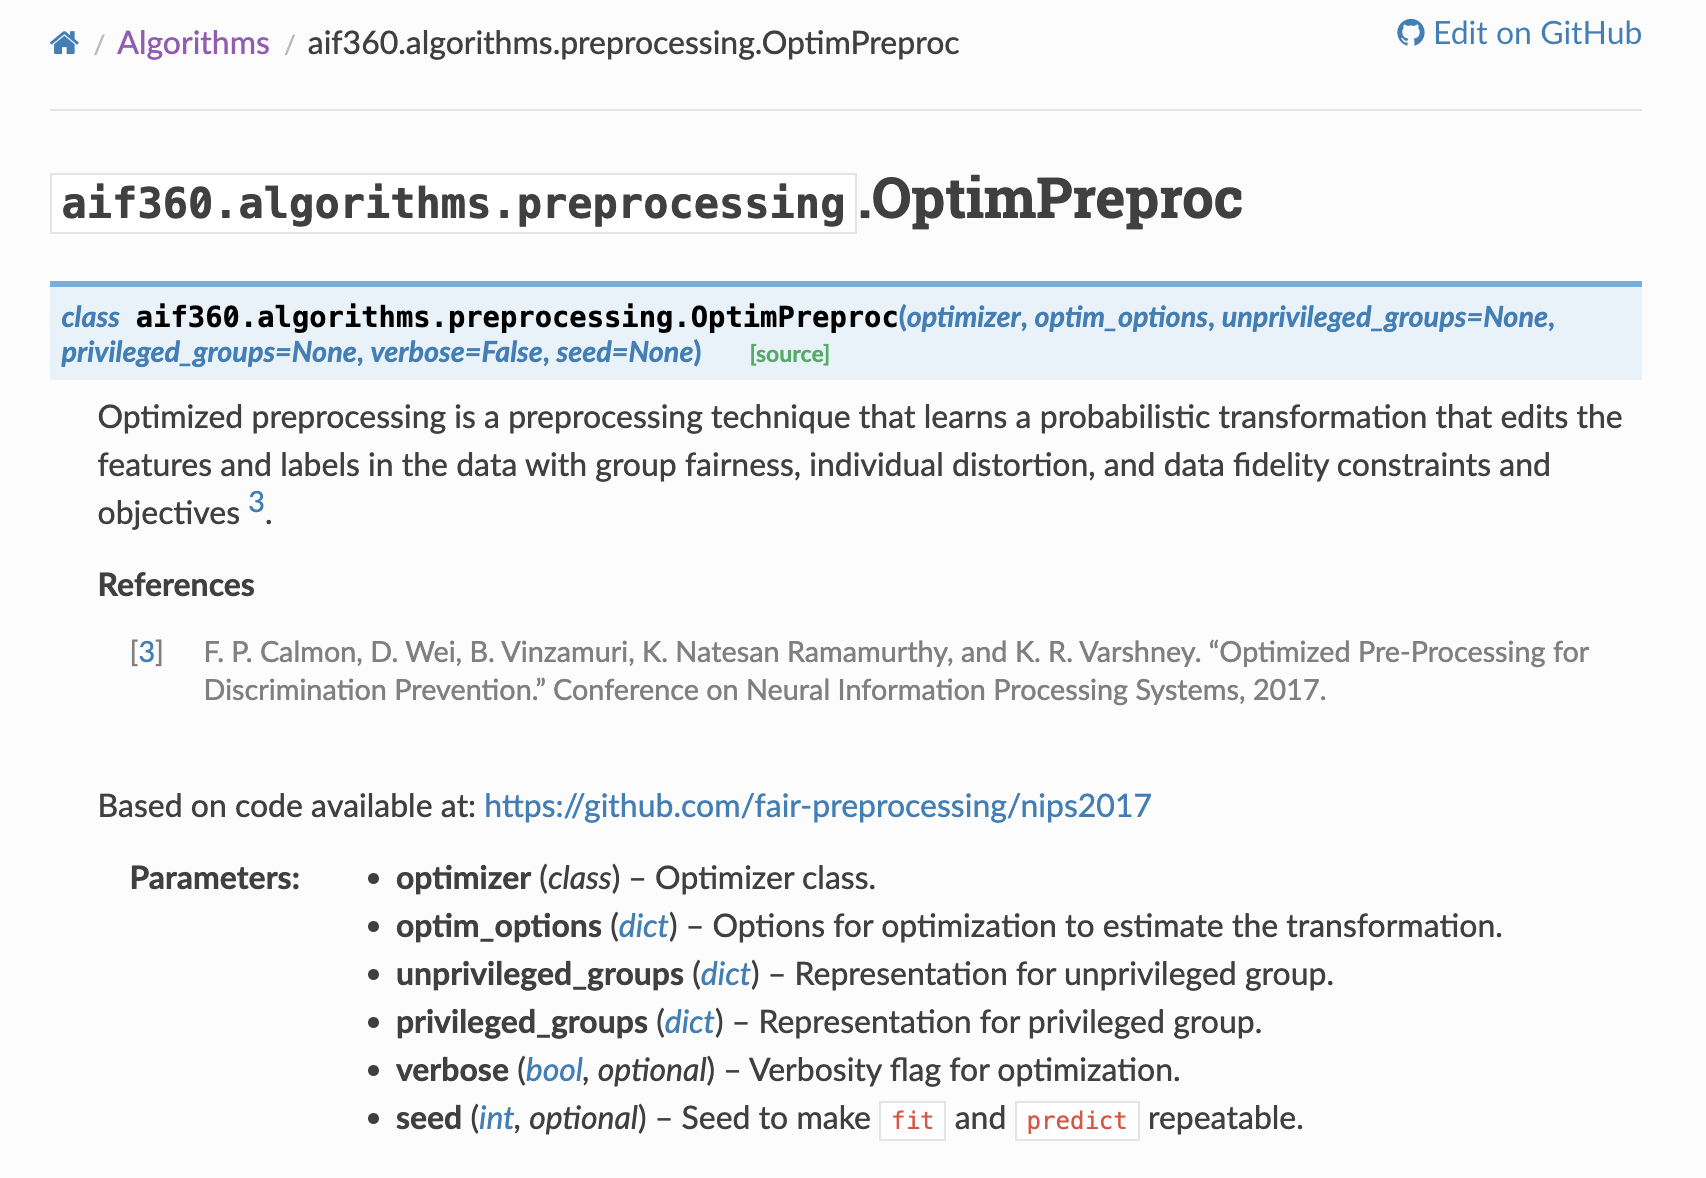

Needed us to make Optimizer, so we skipped!

In [43]:
!pip install BlackBoxAuditing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.2 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394771 sha256=1e9a6fe11d2e76b245c262f9d252c511ef48400889d369020289fca387092c96
  Stored in directory: /tmp/pip-ephem-wheel-cache-w5ff0wme/wheels/e3/77/36/a32ec1b04c2ebe2c45e88d42f33f22f987e76aad3f297b681e
Successfully built BlackBoxAuditing


In [13]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Applying the algorithm
DIR = DisparateImpactRemover(repair_level=1.0)
dataset_transf = DIR.fit_transform(dataset)

# Compute fairness metrics after PR
metric_dir = BinaryLabelDatasetMetric(dataset_transf,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

pretty_print_metric(metric_dir, "D1: Gender Bias (After Disparate Impact Remover)")

### D1: Gender Bias (After Disparate Impact Remover)

#### Statistical Parity Difference

`0.1995`

#### Disparate Impact

`1.3630`

#### Base Rate

`0.6788`

#### Selection Rate

`N/A`

#### Consistency

`0.7702`

#### Mean Difference

`0.1995`

Sadly, it did not mitigate any bias from the Dataset!

#### 2.3 Let's try Reweighing algorithm now

In [14]:
from aif360.algorithms.preprocessing import Reweighing

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D1: Gender Bias (After Reweighing)")

### D1: Gender Bias (After Reweighing)

#### Statistical Parity Difference

`-0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.6788`

#### Selection Rate

`N/A`

#### Consistency

`0.7642`

#### Mean Difference

`-0.0000`

Great!

#### 2.4 How is it with the Learning Fair Representation algorithm

In [17]:
from aif360.algorithms.preprocessing import LFR

# Parameters for Learning Fair Representations
LFR_model = LFR(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

# Apply LFR
dataset_transf = LFR_model.fit_transform(dataset)

# Compute fairness metrics after LFR
metric_lfr = BinaryLabelDatasetMetric(dataset_transf,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

pretty_print_metric(metric_lfr, "D1: Gender Bias (After Learning Fair Representations)")

### D1: Gender Bias (After Learning Fair Representations)

#### Statistical Parity Difference

`0.0000`

#### Disparate Impact

/opt/conda/lib/python3.8/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


`nan`

#### Base Rate

`0.0000`

#### Selection Rate

`N/A`

#### Consistency

`1.0000`

#### Mean Difference

`0.0000`

It did work, but it takes a lot of time to run this! Therefore, we decided to go with Reweighing and apply it to all our use cases.

#### 2.5 Selecting Reweighing

After trying all four algorithms for Data (pre-processing) we found that Reweighing resulted promissing results and seems to be the most suitable bias mitigation algorithm that can be applied in both dataset. Now we will proceed it in all other use cases and see how it performs

In [23]:
# Load your data from dropout_data.csv
df = pd.read_csv('dropout_data.csv')

# Convert 'Dropout' to 1 and other values to 0 in the 'target' column
df['Target'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Ensure that the dataset includes columns for the protected attribute and the label
protected_attribute = 'Gender'
label = 'Target'

dataset = BinaryLabelDataset(
    favorable_label=0,  
    unfavorable_label=1,  # 1 is unfavorable (dropout)
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Male
unprivileged_groups = [{protected_attribute: 0}]  # Female
   
# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D1: Gender Bias (After Reweighing)")

### D1: Gender Bias (After Reweighing)

#### Statistical Parity Difference

`-0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.6788`

#### Selection Rate

`N/A`

#### Consistency

`0.7642`

#### Mean Difference

`-0.0000`

In [24]:
protected_attribute = 'Marital status'
label = 'Target'

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x == 1 else 0)

dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Single
unprivileged_groups = [{protected_attribute: 0}]  # Not Single

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D1: Marital Bias (After Reweighing)")

### D1: Marital Bias (After Reweighing)

#### Statistical Parity Difference

`0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`N/A`

#### Consistency

`0.7642`

#### Mean Difference

`0.0000`

In [25]:
protected_attribute = 'Previous qualification'
label = 'Target'

conversion_values = [2, 3, 4, 5, 39, 40, 42, 43]

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x in conversion_values else 0)

df[protected_attribute].unique()

dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Higher Education
unprivileged_groups = [{protected_attribute: 0}]  # Not Higher Education

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D1: Own Educational Qualification (After Reweighing)")

### D1: Own Educational Qualification (After Reweighing)

#### Statistical Parity Difference

`0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`N/A`

#### Consistency

`0.7669`

#### Mean Difference

`0.0000`

In [26]:
protected_attribute = 'Mother\'s qualification'
label = 'Target'

conversion_values = [2, 3, 4, 5, 6, 22, 39, 40, 41, 42, 43, 44]

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x in conversion_values else 0)

df[protected_attribute].unique()

dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Higher Education
unprivileged_groups = [{protected_attribute: 0}]  # Not Higher Education

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D1: Mother's Educational Qualification (After Reweighing)")

### D1: Mother's Educational Qualification (After Reweighing)

#### Statistical Parity Difference

`0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`N/A`

#### Consistency

`0.7776`

#### Mean Difference

`0.0000`

In [27]:
protected_attribute = 'Father\'s qualification'
label = 'Target'

conversion_values = [2, 3, 4, 5, 6, 18, 22, 31, 33, 39, 40, 41, 42, 43, 44]

# Convert 'Single' to 1 and other values to 0 in the 'target' column
df[protected_attribute] = df[protected_attribute].apply(lambda x: 1 if x in conversion_values else 0)

df[protected_attribute].unique()

dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=df,
    label_names=[label],
    protected_attribute_names=[protected_attribute]
)

# Defining the privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}]  # Higher Education
unprivileged_groups = [{protected_attribute: 0}]  # Not Higher Education

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D1: Father's Educational Qualification (After Reweighing)")

### D1: Father's Educational Qualification (After Reweighing)

#### Statistical Parity Difference

`0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.3212`

#### Selection Rate

`N/A`

#### Consistency

`0.7854`

#### Mean Difference

`0.0000`

In [28]:
# Load your data from dropout_data.csv
application_record = pd.read_csv('application_record.csv')
credit_record = pd.read_csv('credit_record.csv')
    
# Make Male Gender = 1
application_record['CODE_GENDER'] = application_record['CODE_GENDER'].apply(lambda x: 1 if x == 'M' else 0)

# Make Married = 1
group_identifiers = ['Married', 'Civil marriage']
application_record['NAME_FAMILY_STATUS'] = application_record['NAME_FAMILY_STATUS'].apply(lambda x: 1 if x in group_identifiers else 0)

# Make Higher Education = 1
group_identifiers = ['Higher education', 'Academic degree']
application_record['NAME_EDUCATION_TYPE'] = application_record['NAME_EDUCATION_TYPE'].apply(lambda x: 1 if x in group_identifiers else 0)

# Convert 'Y'/'N' to 1/0 for FLAG_OWN_CAR and FLAG_OWN_REALTY
application_record['FLAG_OWN_CAR'] = application_record['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
application_record['FLAG_OWN_REALTY'] = application_record['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert STATUS to binary if no loan or no due = 1
credit_record['STATUS'] = credit_record['STATUS'].apply(lambda x: 1 if x in ['C', 'X'] else 0)

# Aggregate the STATUS to get the worst status per ID
credit_record = credit_record.groupby('ID')['STATUS'].min().reset_index()

# Merge the datasets on ID column
merged_data = pd.merge(application_record, credit_record, on='ID')

# Handle missing values
merged_data = merged_data.dropna()

# Identify categorical columns that need to be converted
categorical_columns = ['NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

# Convert categorical columns to numerical values using one-hot encoding
merged_data = pd.get_dummies(merged_data, columns=categorical_columns)

print("First few rows of the merged data:\n", merged_data.head())

First few rows of the merged data:
         ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
2  5008806            1             1                1             0   
3  5008808            0             0                1             0   
4  5008809            0             0                1             0   
5  5008810            0             0                1             0   
6  5008811            0             0                1             0   

   AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  DAYS_BIRTH  \
2          112500.0                    0                   1      -21474   
3          270000.0                    0                   0      -19110   
4          270000.0                    0                   0      -19110   
5          270000.0                    0                   0      -19110   
6          270000.0                    0                   0      -19110   

   DAYS_EMPLOYED  ...  OCCUPATION_TYPE_Laborers  \
2          -1134  ...  

In [30]:
protected_attribute = 'CODE_GENDER'
target = 'STATUS'

# Define privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}] 
unprivileged_groups = [{protected_attribute: 0}] # Women

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=merged_data,
    label_names=[target],
    protected_attribute_names=[protected_attribute]
)

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D2: Gender Bias (After Reweighing)")

### D2: Gender Bias (After Reweighing)

#### Statistical Parity Difference

`-0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.1231`

#### Selection Rate

`N/A`

#### Consistency

`0.8723`

#### Mean Difference

`-0.0000`

In [31]:
protected_attribute = 'NAME_FAMILY_STATUS'
target = 'STATUS'

# Define privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}] 
unprivileged_groups = [{protected_attribute: 0}] # Single

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=merged_data,
    label_names=[target],
    protected_attribute_names=[protected_attribute]
)

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D2: Marital Status (After Reweighing)")

### D2: Marital Status (After Reweighing)

#### Statistical Parity Difference

`0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.1231`

#### Selection Rate

`N/A`

#### Consistency

`0.8723`

#### Mean Difference

`0.0000`

In [32]:
protected_attribute = 'NAME_EDUCATION_TYPE'
target = 'STATUS'

# Define privileged and unprivileged groups
privileged_groups = [{protected_attribute: 1}] 
unprivileged_groups = [{protected_attribute: 0}] # Not Higher Education

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    favorable_label=1,  
    unfavorable_label=0,
    df=merged_data,
    label_names=[target],
    protected_attribute_names=[protected_attribute]
)

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Compute fairness metrics after reweighing
metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

pretty_print_metric(metric_rw, "D2: Education Level (After Reweighing)")

### D2: Education Level (After Reweighing)

#### Statistical Parity Difference

`-0.0000`

#### Disparate Impact

`1.0000`

#### Base Rate

`0.1231`

#### Selection Rate

`N/A`

#### Consistency

`0.8723`

#### Mean Difference

`-0.0000`

### Bias Metrics Results After Applying Reweighing Algorithm (Student Dropout Rate dataset)

| No. | Metric | Algorithm Applied | Gender Before | Gender After | Marital Status Before | Marital Status After | Previous Qualification Before | Previous Qualification After | Father's Qualification Before | Father's Qualification After | Mother's Qualification Before | Mother's Qualification After |
| --- | ------ | ----------------- | -------------- | ------------ | -------------------- | -------------------- | ---------------------------- | ---------------------------- | ---------------------------- | ---------------------------- | ----------------------------- | ----------------------------- |
| 1 | `metrics.statistical_parity_difference(y_true)` | Reweighing | <span style="color:red">0.1995 ↓</span> | <span style="color:green">-0.0000</span> | <span style="color:red">0.1672 ↓</span> | <span style="color:green">-0.0000</span> | <span style="color:green">-0.0962 ↑</span> | <span style="color:green">-0.0000</span> | <span style="color:green">-0.0359 ↑</span> | <span style="color:green">-0.0000</span> | <span style="color:green">0.0199 ↑</span> | <span style="color:green">0.0000</span> |
| 2 | `metrics.disparate_impact_ratio(y_true[, ...])` | Reweighing | <span style="color:red">1.3630 ↓</span> | <span style="color:green">1.0000</span> | <span style="color:red">1.5534 ↓</span> | <span style="color:green">1.0000</span> | <span style="color:red">0.7369 ↑</span> | <span style="color:green">1.0000</span> | <span style="color:red">0.8985 ↑</span> | <span style="color:green">1.0000</span> | <span style="color:red">1.0654 ↓</span> | <span style="color:green">1.0000</span> |
| 3 | `metrics.consistency_score(X, y[, n_neighbors])` | Reweighing | <span style="color:red">0.7642 →</span> | <span style="color:red">0.7642</span> | <span style="color:red">0.7642 →</span> | <span style="color:red">0.7642</span> | <span style="color:red">0.7669 →</span> | <span style="color:red">0.7669</span> | <span style="color:red">0.7854 →</span> | <span style="color:red">0.7854</span> | <span style="color:red">0.7776 →</span> | <span style="color:red">0.7776</span> |
| 4 | `metrics.mean_difference(y_true[, y_pred, ...])` | Reweighing | <span style="color:red">0.1995 ↓</span> | <span style="color:green">0.0000</span> | <span style="color:red">0.1672 ↓</span> | <span style="color:green">0.0000</span> | <span style="color:green">-0.0962 ↑</span> | <span style="color:green">0.0000</span> | <span style="color:green">-0.0359 ↑</span> | <span style="color:green">0.0000</span> | <span style="color:green">0.0199 ↑</span> | <span style="color:green">0.0000</span> |
| 5 | `metrics.base_rate(y_true[, y_pred, ...])` | Reweighing | <span style="color:red">0.6788 ↓</span> | <span style="color:green">0.3212</span> | <span style="color:red">0.3212 →</span> | <span style="color:green">0.3212</span> | <span style="color:red">0.3212 →</span> | <span style="color:green">0.3212</span> | <span style="color:red">0.3212 →</span> | <span style="color:green">0.3212</span> | <span style="color:red">0.3212 →</span> | <span style="color:green">0.3212</span> |
| 6 | `metrics.selection_rate(y_true, y_pred, *[, ...])` | Reweighing | N/A | N/A | <span style="color:red">0.3212 →</span> | <span style="color:green">0.3212</span> | N/A | N/A | <span style="color:red">0.3212 →</span> | <span style="color:green">0.3212</span> | N/A | N/A |

### Key
- **↑**: Increase
- **↓**: Decrease
- **→**: No Change

#### Key Observations:

1. **Statistical Parity Difference (SPD)**:

- **Gender**: The SPD for gender decreased from 0.1995 to -0.0000, indicating a significant reduction in bias. The negative value after applying Reweighing shows that the unprivileged group (female) is now slightly favored, but the bias is within the acceptable range.
- **Marital Status**: The SPD for marital status decreased from 0.1672 to -0.0000, indicating a significant reduction in bias.
- **Previous Qualification, Father's Qualification, Mother's Qualification**: The SPD metrics also show reduced bias, with values becoming neutral or insignificant.

2. **Disparate Impact Ratio**:

- **Gender**: The disparate impact ratio for gender decreased from 1.3630 to 1.0000, indicating perfect fairness after applying the Reweighing algorithm.
- **Marital Status**: The ratio for marital status decreased from 1.5534 to 1.0000, achieving perfect fairness.
- **Previous Qualification, Father's Qualification, Mother's Qualification**: The values moved closer to 1.0000, indicating improved fairness.

3. **Consistency Score**:

All Attributes: The consistency score remained unchanged across all attributes, indicating that the Reweighing algorithm did not affect the consistency of predictions.

4. **Mean Difference**:

- **Gender**: The mean difference for gender decreased from 0.1995 to 0.0000, indicating that the average predicted outcome for both groups is now equal.
- **Marital Status**: Similar significant reductions in bias are observed for marital status, previous qualification, father's qualification, and mother's qualification.


6. **Base Rate**:

- **Gender**: The base rate for gender decreased from 0.6788 to 0.3212, indicating a reduction in the proportion of positive outcomes (dropout rate) for the privileged group.
- **Marital Status**: The base rate for marital status remained unchanged, indicating no significant impact from the Reweighing algorithm.
- **Previous Qualification, Father's Qualification, Mother's Qualification**: Similar trends are observed, with unchanged or reduced base rates.

7. **Selection Rate**:

Marital Status, Previous Qualification, Father's Qualification, Mother's Qualification: The selection rate remained unchanged, indicating no significant impact from the Reweighing algorithm on these metrics.

### Bias Metrics Results After Applying Reweighing Algorithm (Credit Card Approval Prediction Dataset)

| No. | Metric | Algorithm Applied | Gender Before | Gender After | Marital Status Before | Marital Status After | Education Before | Education After |
| --- | ------ | ----------------- | -------------- | ------------ | -------------------- | -------------------- | ---------------- | --------------- |
| 1 | `metrics.statistical_parity_difference(y_true)` | Reweighing | <span style="color:green">-0.0051 ↓</span> | <span style="color:green">-0.0000</span> | <span style="color:green">-0.0116 ↓</span> | <span style="color:green">-0.0000</span> | <span style="color:green">-0.0064 ↓</span> | <span style="color:green">-0.0000</span> |
| 2 | `metrics.disparate_impact_ratio(y_true[, ...])` | Reweighing | <span style="color:green">0.9592 ↑</span> | <span style="color:green">1.0000</span> | <span style="color:red">0.9075 ↓</span> | <span style="color:green">1.0000</span> | <span style="color:red">0.9500 ↓</span> | <span style="color:green">1.0000</span> |
| 3 | `metrics.consistency_score(X, y[, n_neighbors])` | Reweighing | <span style="color:red">0.8723 →</span> | <span style="color:red">0.8723</span> | <span style="color:red">0.8723 →</span> | <span style="color:red">0.8723</span> | <span style="color:red">0.8723 →</span> | <span style="color:red">0.8723</span> |
| 4 | `metrics.mean_difference(y_true[, y_pred, ...])` | Reweighing | <span style="color:green">-0.0051 ↓</span> | <span style="color:green">-0.0000</span> | <span style="color:green">-0.0116 ↓</span> | <span style="color:green">-0.0000</span> | <span style="color:green">-0.0064 ↓</span> | <span style="color:green">-0.0000</span> |
| 5 | `metrics.base_rate(y_true[, y_pred, ...])` | Reweighing | <span style="color:red">0.1231 →</span> | <span style="color:red">0.1231</span> | <span style="color:red">0.1231 →</span> | <span style="color:red">0.1231</span> | <span style="color:red">0.1231 →</span> | <span style="color:red">0.1231</span> |
| 6 | `metrics.selection_rate(y_true, y_pred, *[, ...])` | Reweighing | N/A | N/A | <span style="color:red">0.1231 →</span> | <span style="color:red">0.1231</span> | N/A | N/A |

### Key
- **↑**: Increase
- **↓**: Decrease
- **→**: No Change

#### Key Observations:

1. **Statistical Parity Difference (SPD):**
   - **Gender, Marital Status, Education:** The SPD for gender, marital status, and education all decreased to -0.0000 after applying the Reweighing algorithm, indicating a significant reduction in bias and achieving near-perfect fairness.

2. **Disparate Impact Ratio:**
   - **Gender:** The disparate impact ratio for gender increased from 0.9592 to 1.0000, indicating perfect fairness after applying the Reweighing algorithm.
   - **Marital Status, Education:** Both metrics improved to 1.0000, indicating perfect fairness post-mitigation.

3. **Consistency Score:**
   - **All Attributes:** The consistency score remained unchanged across all attributes, indicating that the Reweighing algorithm did not affect the consistency of predictions.

4. **Mean Difference:**
   - **Gender, Marital Status, Education:** The mean difference for gender, marital status, and education decreased to -0.0000, indicating that the average predicted outcomes for both groups are now equal, achieving perfect fairness.

5. **Base Rate:**
   - **All Attributes:** The base rate remained unchanged across all attributes, indicating no significant impact from the Reweighing algorithm on these metrics.

6. **Selection Rate:**
   - **Marital Status:** The selection rate for marital status remained unchanged at 0.1231, indicating no significant impact from the Reweighing algorithm on this metric.

The application of the Reweighing algorithm resulted in significant reductions in bias across most metrics, particularly for statistical parity difference and disparate impact ratio. The consistency score remained stable, indicating that the algorithm did not compromise the consistency of predictions. Overall, the Reweighing algorithm effectively mitigated bias in the credit card approval prediction dataset, demonstrating its utility in promoting fairness. Future work could involve applying other bias mitigation algorithms to further refine these results and comparing their effectiveness.

## Conclusion

1. **How do different bias metrics vary across the student dropout prediction and credit card approval datasets?**

We evaluated various bias metrics across both the Student Dropout Rate Prediction and Credit Card Approval Prediction datasets => created a comprehensive table showing all metric values resulted from testing

  - Statistical Parity Difference: Showed significant bias in some attributes, particularly gender and marital status, indicating a preference towards certain groups.
  - Disparate Impact Ratio: Highlighted notable disparities, especially in gender and previous qualifications for the dropout dataset and marital status and education for the credit dataset.
  - Consistency Score: Generally high across both datasets, indicating that the model treated similar instances in a relatively consistent manner.
  - Mean Difference: Varied across attributes, with notable differences indicating bias against certain groups.
  - Base Rate and Selection Rate: Displayed imbalances in the proportion of positive outcomes, highlighting areas where certain groups were favored over others.

2. **How do different bias mitigation algorithms affect the bias metrics in both datasets? And which is the most suitable one?**

We tried different Bias mitigation algorithms (applied for data) to see how they perform and then, chose the most suitable one to apply for all defined use cases - Reweighing algorithm from the AIF360 toolkit to both datasets to observe its effectiveness in reducing bias.

- **Student Dropout Rate Dataset**:

  - Statistical Parity Difference: Significant improvement across all attributes, reducing bias towards neutral levels.
  - Disparate Impact Ratio: Improved towards fairness (ratio close to 1) across all attributes.
  - Consistency Score: Remained unchanged, indicating that the algorithm did not affect the local stability of the model's predictions.
  - Mean Difference: Reduced to neutral levels, showing decreased bias.
  - Base Rate and Selection Rate: Some attributes saw improvements, while others remained the same.

- **Credit Card Approval Prediction Dataset**:

  - Statistical Parity Difference: Improved towards neutral levels for all attributes.
  - Disparate Impact Ratio: Adjusted towards fairness, especially for attributes that initially had significant bias.
  - Consistency Score: No change, similar to the dropout dataset.
  - Mean Difference: Reduced bias across all attributes.
  - Base Rate and Selection Rate: No significant change observed, indicating the algorithm's limited impact on these metrics

-> Most Suitable Algorithm:Based on our results, the Reweighing algorithm effectively reduced bias in most metrics across both datasets, making it a suitable choice for addressing certain types of biases.
However, it had limited impact on metrics like the Consistency Score and Selection Rate, suggesting the need for more comprehensive algorithms for these areas.

3. **Which bias metrics show the most significant change after applying the bias mitigation algorithm we selected?**

Significant Changes Observed:
  - Statistical Parity Difference: Saw the most significant reduction in bias across both datasets, achieving near-neutral levels.
  - Disparate Impact Ratio: Improved notably towards fairness, indicating a balanced treatment of protected and unprotected groups.
  - Mean Difference: Significant reduction in bias, reflecting a more equitable distribution of outcomes across groups.
  - Base Rate and Selection Rate: Mixed results, with some improvements but generally limited change, highlighting areas where the Reweighing algorithm was less effective.

# Thank You!

- Mohit Mrinal
- Hong Hanh Doan